In [1]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_excel(r"../dano_base.xlsx")

In [3]:
df = df[df.age_segment != 'Пусто']
df = df.dropna(subset=['age_segment'])
new_column = {'0-13':1,
             '14-17':2,
             '18-22':3,
             '23-25':4,
             '26-30':5,
             '31-35':6,
             '36-40':7,
             '41-45':8,
             '46-50':9,
             '51-55':10,
             '56-60':11,
             '61-65':12,
             '65+':13}
df.insert(1,'age_category',df['age_segment'].map(new_column))

df['trial_type'] = df['trial_type'].fillna(0)
df = df[(df['trial_type'] == '1 mon')]

df = df.dropna(subset=['subscription_time'])
df['sub_time_in_days'] = df['subscription_time'].apply(lambda x: x/86400)

In [4]:
df["cancelled_trial"] = df["sub_time_in_days"] <= 31
df.cancelled_trial = df.cancelled_trial.map({True : 1, False : 0})

In [5]:
res = pl.from_pandas(df).group_by("age_category").agg(
    total_people = pl.col("cancelled_trial").count(),
    cancelled_trial = pl.col("cancelled_trial").sum(),
    fraction_cancelled = pl.col("cancelled_trial").mean(),
    cancelled_trial_flg = pl.col("cancelled_trial"),
    std = pl.col("cancelled_trial").std(),
    se = pl.col("cancelled_trial").std()/(pl.col("cancelled_trial").count()**0.5),
    ci_95p = (pl.col("cancelled_trial").std()/(pl.col("cancelled_trial").count()**0.5))*1.96
).to_pandas()
res = res.sort_values(by="age_category").reset_index(drop=True)
res

,age_category,total_people,cancelled_trial,fraction_cancelled,cancelled_trial_flg,std,se,ci_95p
0,1,94,58,0.617021,"[1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, ...",0.488720,0.050408,0.098799
1,2,7061,4102,0.580938,"[1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, ...",0.493441,0.005872,0.011510
2,3,7916,3969,0.501390,"[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, ...",0.500030,0.005620,0.011015
3,4,2702,1349,0.499260,"[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, ...",0.500092,0.009621,0.018857
4,5,3732,1684,0.451233,"[0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, ...",0.497683,0.008147,0.015968
5,6,3200,1329,0.415312,"[1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, ...",0.492853,0.008712,0.017076
6,7,2233,897,0.401702,"[1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, ...",0.490352,0.010377,0.020339
7,8,1441,529,0.367106,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",0.482183,0.012702,0.024896
8,9,907,301,0.331863,"[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ...",0.471142,0.015644,0.030662
9,10,506,169,0.333992,"[0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, ...",0.472104,0.020988,0.041136


In [7]:
res_new = res.explode("cancelled_trial_flg")
res_new.cancelled_trial_flg = pd.to_numeric(res.explode("cancelled_trial_flg").cancelled_trial_flg)

<ErrorbarContainer object of 3 artists>

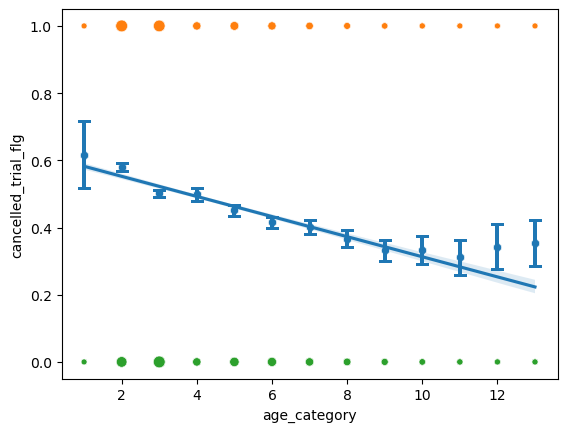

In [8]:
sns.regplot(data=res_new, x = "age_category", y = "cancelled_trial_flg",scatter=False)
sns.scatterplot(data=res_new, x = "age_category", y = "fraction_cancelled")
sns.scatterplot(data=res_new[res_new["cancelled_trial_flg"]==1], x = "age_category", y = "cancelled_trial_flg", size="cancelled_trial", legend = False)
sns.scatterplot(data=res_new[res_new["cancelled_trial_flg"]==0], x = "age_category", y = "cancelled_trial_flg", size=(res_new[res_new["cancelled_trial_flg"]==0]["total_people"] - res_new[res_new["cancelled_trial_flg"]==0]["cancelled_trial"]), legend=False)
plt.errorbar(data=res_new, x = "age_category", y = "fraction_cancelled", yerr="ci_95p", fmt="none", capsize=4)

In [82]:
fig = px.scatter(x = res_new["age_category"], y = res_new["cancelled_trial_flg"], trendline="ols")
fig.show()
results = px.get_trendline_results(fig)
print(results)
results.px_fit_results.iloc[0].summary()

                                      px_fit_results
0  <statsmodels.regression.linear_model.Regressio...


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     641.0
Date:                Thu, 14 Dec 2023   Prob (F-statistic):          5.62e-140
Time:                        00:01:00   Log-Likelihood:                -21787.
No. Observations:               30491   AIC:                         4.358e+04
Df Residuals:                   30489   BIC:                         4.359e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6122      0.006    102.731      0.000       0.601       0.624
x1            -0.0299      0.001    -25.318      0.000      -0.032      -0.028
==============================================================================
Omnibus:                   109834.949   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4677.905
Skew:                           0.076   Prob(JB):                         0.00
Kurtosis:                       1.087   Cond. No.                         10.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""